<a href="https://www.kaggle.com/code/nishantpatel54/30day-stock-forecast-lstm?scriptVersionId=146661051" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 51.4 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=290463 sha256=173236d152c868928d87ef174439de5cbd7adf14fb4acf6d224349b266acb839
  Stored in directory: /root/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built peewee


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

ticker = 'AAPL'
lookback = 60
forecast = 30
end_train='2023-08-01'
start_val='2023-08-02'
#account for 3 years of trading days.
trading_day = 252
days_in_year = 365
period = 4
history = int((365*period)+((365-252)*period))

start_train = datetime.datetime.strptime(end_train, '%Y-%m-%d').date() - datetime.timedelta(days = history)
start_train = start_train.strftime("%Y-%m-%d")

dataset = yf.download(ticker, start=start_train, end=end_train)

dataset_val = yf.download(ticker, start_val)

train_set = dataset[['Close']].fillna(method='ffill')
train_set = train_set.values.reshape(-1,1)

val_set = dataset_val[['Close']].fillna(method='ffill').head(lookback+forecast)
val_set = val_set.values.reshape(-1,1)

train_set.shape, val_set.shape, start_train

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


((1317, 1), (52, 1), '2018-05-07')

In [3]:
sc = MinMaxScaler(feature_range=(0,1))
sc = sc.fit(train_set)
train_set_scaled = sc.transform(train_set)

sc_val = MinMaxScaler(feature_range=(0,1))
sc_val = sc_val.fit(val_set)
val_set_scaled = sc_val.transform(val_set)
val_set_scaled[:10], train_set_scaled[:10]

(array([[1.        ],
        [0.93634298],
        [0.52189653],
        [0.38013589],
        [0.42302512],
        [0.3503389 ],
        [0.34040657],
        [0.3322798 ],
        [0.40767541],
        [0.31693008]]),
 array([[0.06676404],
        [0.06814686],
        [0.07018225],
        [0.07434625],
        [0.07209334],
        [0.07140969],
        [0.06875282],
        [0.0714563 ],
        [0.06960738],
        [0.06855082]]))

In [4]:
X_train=[]
y_train=[]
X_val=[]
y_val=[]

for i in range(lookback, len(train_set_scaled) - forecast + 1):
    X_train.append(train_set_scaled[i - lookback : i])
    y_train.append(train_set_scaled[i : i + forecast])

for i in range(lookback, len(val_set_scaled) - forecast + 1):
    X_val.append(val_set_scaled[i - lookback : i])
    y_val.append(val_set_scaled[i : i + forecast])
    
X_train=np.array(X_train)
y_train=np.array(y_train)
X_val=np.array(X_val)
y_val = np.array(y_val)


In [5]:
#model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)))
#model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
#model.add(Dropout(0.5))
model.add(LSTM(units=100,return_sequences=True))
#model.add(Dropout(0.5))
model.add(LSTM(units=100,return_sequences=True))
#model.add(Dropout(0.5))
model.add(LSTM(units=100,return_sequences=False))
#model.add(Dropout(0.5))
model.add(Dense(forecast))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           60400     
                                                                 
 lstm_2 (LSTM)               (None, 60, 100)           80400     
                                                                 
 lstm_3 (LSTM)               (None, 60, 100)           80400     
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 30)                3030      
                                                                 
Total params: 315,030
Trainable params: 315,030
Non-trai

1. Adding Dropout layers to avoid overfitting and get a flat forecast compared to not using dropouts. 
2. Inner dropout is higher than input layer to avoid any adverse effects.

* We are adjusting the number of nodes based on the dropout rate, proposed number of nodes/dropout rate. hidden = 50/0.5 = 100

In [6]:
#train

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
39/39 [==============================] - 19s 256ms/step - loss: 0.0450
Epoch 2/100
39/39 [==============================] - 10s 265ms/step - loss: 0.0052
Epoch 3/100
39/39 [==============================] - 10s 256ms/step - loss: 0.0050
Epoch 4/100
39/39 [==============================] - 10s 257ms/step - loss: 0.0053
Epoch 5/100
39/39 [==============================] - 10s 264ms/step - loss: 0.0049
Epoch 6/100
39/39 [==============================] - 10s 260ms/step - loss: 0.0049
Epoch 7/100
39/39 [==============================] - 10s 254ms/step - loss: 0.0049
Epoch 8/100
39/39 [==============================] - 10s 267ms/step - loss: 0.0045
Epoch 9/100
39/39 [==============================] - 10s 259ms/step - loss: 0.0044
Epoch 10/100
39/39 [==============================] - 10s 258ms/step - loss: 0.0040
Epoch 11/100
39/39 [==============================] - 10s 267ms/step - loss: 0.0041
Epoch 12/100
39/39 [==============================] - 10s 261ms/step - loss: 0.0046
E

1/1 [==============================] - 2s 2s/step
         Date       Close
0  2023-08-02  192.580002
1  2023-08-03  191.169998
2  2023-08-04  181.990005
3  2023-08-07  178.850006
4  2023-08-08  179.800003
5  2023-08-09  178.190002
6  2023-08-10  177.970001
7  2023-08-11  177.789993
8  2023-08-14  179.460007
9  2023-08-15  177.449997
10 2023-08-16  176.570007
11 2023-08-17  174.000000
12 2023-08-18  174.490005
13 2023-08-21  175.839996
14 2023-08-22  177.229996
15 2023-08-23  181.119995
16 2023-08-24  176.380005
17 2023-08-25  178.610001
18 2023-08-28  180.190002
19 2023-08-29  184.119995
20 2023-08-30  187.649994
21 2023-08-31  187.869995
22 2023-09-01  189.460007
23 2023-09-05  189.699997
24 2023-09-06  182.910004
25 2023-09-07  177.559998
26 2023-09-08  178.179993
27 2023-09-11  179.360001
28 2023-09-12  176.300003
29 2023-09-13  174.210007


/tmp/ipykernel_20/1040673157.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_past['Forecast'].iloc[-1] = dataset_past['Actual'].iloc[-1]


(           Date      Actual    Forecast
 0    2018-05-07   46.290001         NaN
 1    2018-05-08   46.512501         NaN
 2    2018-05-09   46.840000         NaN
 3    2018-05-10   47.509998         NaN
 4    2018-05-11   47.147499         NaN
 ...         ...         ...         ...
 1312 2023-07-25  193.619995         NaN
 1313 2023-07-26  194.500000         NaN
 1314 2023-07-27  193.220001         NaN
 1315 2023-07-28  195.830002         NaN
 1316 2023-07-31  196.449997  196.449997
 
 [1317 rows x 3 columns],
                  Close    Forecast
 Date                              
 2023-07-31  196.449997  196.449997
 2023-08-02  192.580002  189.208923
 2023-08-03  191.169998  183.735428
 2023-08-04  181.990005  190.874329
 2023-08-07  178.850006  188.701828
 2023-08-08  179.800003  183.244644
 2023-08-09  178.190002  188.338120
 2023-08-10  177.970001  185.677734
 2023-08-11  177.789993  182.106766
 2023-08-14  179.460007  183.849411
 2023-08-15  177.449997  185.503983
 2023-08-16 

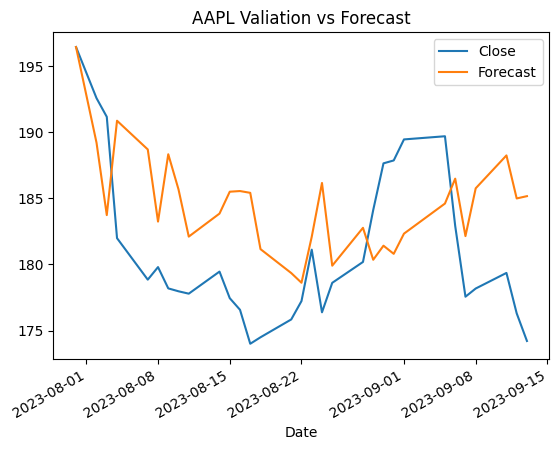

In [7]:
X_ = train_set_scaled[-lookback:]
X_ = X_.reshape(1, lookback, 1)

y_ = model.predict(X_).reshape(-1,1)
y_ = sc.inverse_transform(y_)

dataset_past = dataset[['Close']].reset_index()
dataset_past.rename(columns={'index':'Date','Close':'Actual'},inplace=True)
dataset_past['Date'] = pd.to_datetime(dataset_past['Date'])
dataset_past['Forecast'] = np.nan
dataset_past['Forecast'].iloc[-1] = dataset_past['Actual'].iloc[-1]


dataset_future = dataset_val[['Close']].reset_index()
dataset_future = dataset_future.head(forecast)
print(dataset_future)
dataset_future.rename(columns={'index':'Date','Close':'Validation'})
dataset_future['Date'] = pd.to_datetime(dataset_future['Date'])
dataset_future['Forecast'] = y_.flatten()
dataset_future.set_index('Date', inplace=True)

data=[]
insert_first = {'Date':dataset_past['Date'].iloc[-1], 'Close':dataset_past['Actual'].iloc[-1], 'Forecast':dataset_past['Actual'].iloc[-1]}
data.insert(0,insert_first)
data=pd.DataFrame(data)
data.set_index('Date', inplace=True)
dataset_future = pd.concat([data, dataset_future])


dataset_future.plot(title=ticker + " Valiation vs Forecast")
dataset_past, dataset_future

* With an increased dropout rate on the inner layers it does a better job of forecasting the general trend of the stock over the next 30 training days. 
* Main problem with such a linear forecast is we can't really have a best time to buy and sell the stock over the next 30 days, just take a fixed position either long or short at the start of the trend till the end. For example on August 01, 2022 you would short the stock as we forecast it to drop by Sept 15,2022.